In [1]:
%matplotlib inline
from helpers import *
props = dict(facecolor='black', width=1, headwidth=10)    

## Pre-processing Stuff
You can probably ignore this unless you need to restart the jupyter notebook

In [2]:
untar("../results/scale-workers-1M-4-71537/out/semanticPerf.4.tar.gz")
shutil.move("semanticPerf.4", "tmp/semanticPerf.4")
ret = os.system("cat tmp/semanticPerf.4 | grep DBMemoryGet > tmp/keyspace.log")
dfs = {} # global data structure with parsed data
df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
jobname = ("4 Node, 1M", "DBMemoryGet", "4")
dfs[jobname] = {}
dfs[jobname]['DF_KEY_TIMES'] = {}
dfs[jobname]['DF_KEY_COUNT'] = {}
dfs[jobname]['DF_KEY_TIMES'] = df_op
dfs[jobname]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
dfs[jobname]['DF_KEY_COUNT'].columns=['key', 'count']
df = clean_df(dfs, ("4 Node, 1M", "DBMemoryGet", "4"))

# The Algorithm
Going left to right:
- the minimum takes values from other regimes
- thresholds for key-accesses-within-window or key-evictions 

The new algorithm goes right to left:
- tracks the minimum value we have seen thus far for each point
- for points z, y, x, if the min is the same, we are in a regime
  - although the min might not have shown up in y, we had seen it in z, so for y we know we are in z's fan
  - this is **most likely** to work because accesses to the bottom of the fans are more dense
- *key insight*: we cluster based on minimum value, which can only be achieved by going right to left

1
1
1
2
2

1
1
2
1
2
1
1
1
1

1
1
1
1

1

1
3
6
1


1
1
1
1
47
1
2
6


1
3


1
1


7
1
26
5
2

2
51

8
125
117
14
1

5
37
1
1
1
5
1
1
1



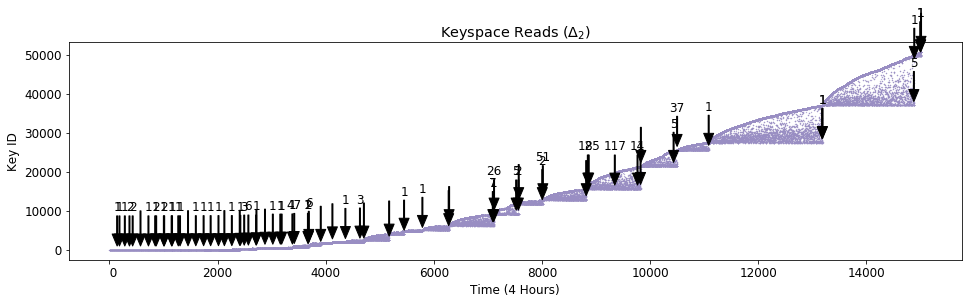

In [9]:
def find_regimes(ax, df, window=5, ymax=50000, draw_regimes=True):
    
    # parse into matrix of (timestamp, id) pairs
    TS_INDEX = 0; ID_INDEX = 1;     
    tss  = df['shift'].astype(int)
    keys = df['id'].astype(int)
    data = np.squeeze(np.asarray(np.matrix(zip(tss, keys))))
    
    # first pass: detect all possible fans
    fans       = []                       # access regime fans we have found
    fan_end    = data[-1][TS_INDEX]       # the end of the current fan in time
    fan_end_i  = len(data) - 1            # the end of the current fan in index
    fan_bottom = data[-1][ID_INDEX]       # current lowest value seen, for this fan  
    fan_top    = 0                        # the highest key in the fan
    for i in range(len(data)-1, -1, -1):  # iterate backwards!
        TS, ID = data[i]
        if ID < fan_bottom:               # we have found a new fan!
            fan = ((TS, fan_end), (fan_bottom, fan_top), (i, fan_end_i))
            fans.append(fan)
            fan_bottom = ID
            fan_top = 0
            fan_end = TS
            fan_end_i = i
        if ID > fan_top:                  # update the top of this fan                    
            fan_top = ID
    last_fan = ((0, fan_end), (ID, fan_top), (0, fan_end_i))
    fans.append(last_fan)
    fans.reverse()

    # second pass: avoid false positives by checking height of each fan
    #filtered = []                         # avoid false positives
    #((start, _), _, (start_i, _)) = fans[0]
    #for i in range(0, len(fans)-1):
    #    ((_, fan_end),(fan_bottom, fan_top), (_, fan_end_i)) = fans[i]
    #    if fans[i+1]:
    #        ((_, next_fan_end), (next_fan_bottom, next_fan_top), (_, next_fan_end_i)) = fans[i+1]
    #        if fan_top < next_fan_bottom:
    #            filtered.append(((start, next_fan_end), (fan_bottom, fan_top), (start_i, next_fan_end_i)))
    #            start = fan_end
    #            start_i = fan_end_i
    #    else:
    #        filtered.append(fans[i])
    filtered = fans
            
    # third pass: add max distance of two minima to each fan
    for f in range(len(filtered)):
        ((fan_start, fan_end),(fan_bottom, fan_top), (fan_start_i, fan_end_i)) = filtered[f]
        tminima = []   # minima in time
        minima = []    # minima in index
        for i in range(fan_start_i, fan_end_i+1):
            #if data[i][ID_INDEX] == fan_bottom:
            if fan_bottom <= data[i][ID_INDEX] < fan_bottom + window:
                tminima.append(data[i][TS_INDEX])
                minima.append(i)
        tdists = [tminima[i+1] - tminima[i] for i in range(len(tminima)-1)]
        dists = [minima[i+1] - minima[i] for i in range(len(minima)-1)]
        if tdists and dists:
            filtered[f] = ((fan_start, fan_end), (fan_bottom, fan_top), (fan_start_i, fan_end_i), (max(tdists), max(dists)))
   
    ax.scatter(tss, keys, s=0.1, color='#998ec3') # plot the keyspace (purple dots)
    rlast = filtered[0]                           # plot an arrow where fans are detected
    for r in filtered:
        if r[0][0] - rlast[0][0] > window:
            if len(r) > 3:
                s = str(r[3][0])
            else:
                s = ""
            print s
            ax.annotate(s, xy=(r[0][0], r[1][0]+1000), xytext=(r[0][0], r[1][0]+10000), arrowprops=props, ha="center")
            rlast = r    
    # cleanup graphs
    ax.set_title(r'Keyspace Reads ($\Delta_2$)')
    ax.set_ylabel("Key ID")
    ax.set_xlabel("Time (4 Hours)")   
    labels = ['{:3.0f}'.format(x) for x in ax.get_yticks()]
    labels[0] = ""
    ax.set_yticklabels(labels)
    labels = ['{:3.0f}'.format(x) for x in ax.get_xticks()]
    labels[0] = ""
    ax.set_xticklabels(labels)        

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
find_regimes(ax, df)

[{'bottom': 1, 'end': 186, 'start': 0, 'top': 1},
 {'bottom': 2, 'end': 285, 'start': 143, 'top': 2},
 {'bottom': 3, 'end': 371, 'start': 186, 'top': 3},
 {'bottom': 4, 'end': 430, 'start': 285, 'top': 4},
 {'bottom': 5, 'end': 575, 'start': 371, 'top': 5},
 {'bottom': 6, 'end': 575, 'start': 430, 'top': 6},
 {'bottom': 7, 'end': 722, 'start': 575, 'top': 7},
 {'bottom': 8, 'end': 847, 'start': 575, 'top': 8},
 {'bottom': 10, 'end': 1007, 'start': 847, 'top': 10},
 {'bottom': 13, 'end': 1013, 'start': 1007, 'top': 13},
 {'bottom': 18, 'end': 1159, 'start': 1151, 'top': 18},
 {'bottom': 25, 'end': 1454, 'start': 1274, 'top': 27},
 {'bottom': 36, 'end': 1454, 'start': 1306, 'top': 48},
 {'bottom': 49, 'end': 1454, 'start': 1454, 'top': 49},
 {'bottom': 50, 'end': 1598, 'start': 1454, 'top': 50},
 {'bottom': 51, 'end': 1599, 'start': 1454, 'top': 60},
 {'bottom': 61, 'end': 1599, 'start': 1598, 'top': 61},
 {'bottom': 62, 'end': 1742, 'start': 1599, 'top': 62},
 {'bottom': 63, 'end': 1872

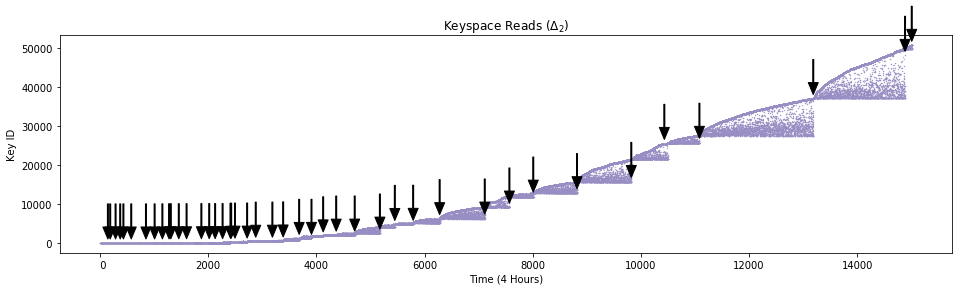

In [5]:
def find_regimes(df):
    TS_INDEX = 0; ID_INDEX = 1;           # parse into matrix of (timestamp, id) pairs
    data = np.squeeze(np.asarray(np.matrix(zip(df['shift'].astype(int), df['id'].astype(int)))))
    
    fans = []                             # 1st pass: detect all possible fans
    fan  = {'start':  None, 'end': data[-1][TS_INDEX], 'top': None, 'bottom': data[-1][ID_INDEX]}
    for i in range(len(data)-1, -1, -1):  # iterate backwards!
        TS, ID = data[i]
        if ID < fan['bottom']:            # we have found a new fan!
            fan['start'] = TS             # complete the fan
            fans.append(fan)              # save the fan and reset
            fan = {'start': None, 'end': TS, 'top': 0, 'bottom': ID}
        if ID > fan['top']:
            fan['top'] = ID
    fan['start'] = 0
    fans.append(fan)
    fans.reverse()   

    regimes = []                         # 2nd pass: avoid false positives; check fan height
    for i in range(0, len(fans)-1):
        if fans[i]['top'] < fans[i+1]['bottom']: 
            fans[i]['end'] = fans[i+1]['end']
            regimes.append(fans[i])
    regimes.append(fans[i])
    return regimes

def plot_regimes(ax, regimes, window=5):
    ax.scatter(df['shift'].astype(int), df['id'].astype(int), s=0.1, color='#998ec3') # plot the keyspace (purple dots)
    ax.set_title(r'Keyspace Reads ($\Delta_2$)')
    ax.set_ylabel("Key ID")
    ax.set_xlabel("Time (4 Hours)")   
    ax.set_yticklabels(['{:3.0f}'.format(x) for x in ax.get_yticks()])
    ax.set_xticklabels(['{:3.0f}'.format(x) for x in ax.get_xticks()])        
    
    last_fan = regimes[0]                        # plot the fans
    for fan in regimes:
        if fan['start'] - last_fan['start'] > window:
            ax.annotate("",  arrowprops=props, ha="center", xy=(fan['start'], fan['top']+1000), xytext=(fan['start'], fan['top']+10000))    
        last_fan = fan
        
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
regimes = find_regimes(df)
plot_regimes(ax, regimes)
regimes

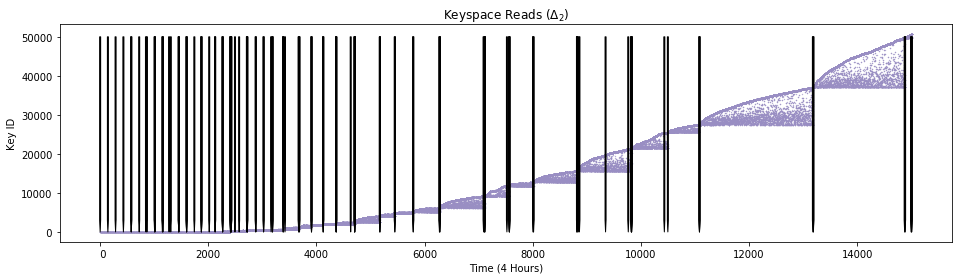

In [6]:
def plot_regimes(ax, regimes, window=5):
    ax.scatter(df['shift'].astype(int), df['id'].astype(int), s=0.1, color='#998ec3') # plot the keyspace (purple dots)
    ax.set_title(r'Keyspace Reads ($\Delta_2$)')
    ax.set_ylabel("Key ID")
    ax.set_xlabel("Time (4 Hours)")   
    ax.set_yticklabels(['{:3.0f}'.format(x) for x in ax.get_yticks()])
    ax.set_xticklabels(['{:3.0f}'.format(x) for x in ax.get_xticks()])        
        
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plot_regimes(ax, regimes)
regimes = [15008,15006,15003,14996,14885,14884,14877,13189,13187,13180,11083,11083,11082,10498,10433,9829,9828,9826,9823,9823,9822,9766,9346,8863,8847,8819,8819,8818,8817,8015,8009,8005,7569,7569,7568,7563,7522,7113,7112,7112,7112,7107,7090,6282,6282,6278,6274,5790,5788,5450,5449,5173,5173,5173,4708,4708,4707,4707,4706,4633,4366,4365,4365,4364,4125,4124,4124,3909,3908,3908,3687,3680,3674,3671,3418,3385,3385,3384,3188,3187,3185,3161,3023,3022,2878,2877,2721,2719,2718,2713,2570,2493,2423,2423,2423,2421,2414,2412,2411,2410,2410,2265,2265,2264,2126,2126,2017,1873,1873,1872,1742,1599,1599,1598,1454,1454,1454,1306,1274,1159,1158,1151,1013,1012,1007,865,847,722,575,575,430,285,143,0]
for fan in regimes:
    ax.annotate("",  arrowprops=dict(facecolor='black', width=1, headwidth=1), ha="center", 
                xy=(fan, 0), 
                xytext=(fan, 50000))    


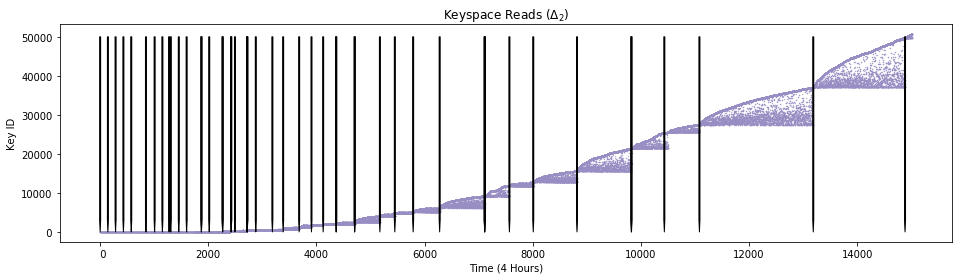

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plot_regimes(ax, regimes)
regimes = [0,143,285,430,575,847,1007,1151,1274,1306,1454,1599,1872,1873,2017,2264,2265,2423,2423,2493,2718,2719,2721,2878,3185,3384,3680,3908,4124,4364,4365,4707,4707,5173,5449,5788,6278,7112,7112,7112,7568,8009,8818,9822,9826,10433,11082,13187,14884]
for fan in regimes:
    ax.annotate("",  arrowprops=dict(facecolor='black', width=1, headwidth=1), ha="center", 
                xy=(fan, 0), 
                xytext=(fan, 50000))   
#ax.set_xlim(0, 500)
#ax.set_ylim(0, 1000)

